# Supervised Learning: Decision Trees

For methods like support vector machines to work well, it requires identifying an appropriate kernel function, which is not always straightforward or intuitive.

An alternative to this is to perform statistical learning more directly, say, as a combination of the predictors (features). An **adaptive basis-function model** (ABM) is one example of this.

$$f(x) = w_0 + \sum_{j=1}^k w_j \phi_j(\mathbf{x})$$

here, $\phi_j$ is a *basis function*, which is typically parametric:

$$\phi_j(\mathbf{x}) = \phi_j(\mathbf{x}|\alpha_j)$$

The parameter set for this model is thus $\theta = \{\mathbf{w} = w_0,\ldots,w_k; \mathbf{\alpha} = \alpha_1, \ldots, \alpha_k\}$. This model is *not* linear in the parameters.


**Decision trees** use an ABM to *recursively partition* the space of predictor variables into a piecewise-constant response surface. We can consider each component $j=1,\ldots,k$ to be a region in the response surface, and $w_j$ the expected response in that region.

$$f(x) = \sum_{j=1}^k w_j I(\mathbf{x} \in R_j)$$

Each paramter $\alpha_j$ encodes both (1) a variable used for splitting and (2) the corresponding threshold value. Specifically, the basis functions define the regions, and the weights encode the response value in each region.

This particular formulation implies a regression-type model, but we can generalize this to classification by storing the *distribution over classes* in each leaf, instead of the mean response.

To get a sense of how decision trees work, consider the diabetes dataset that we have seen previously. In the plot below, the response variable (`target`, an index of disease progression) is color-coded as a function of two variables, metabolic rate (`bmi`) and a blood serum measurement (`ltg`).

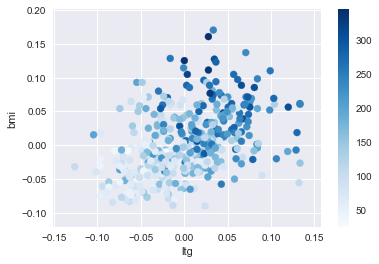

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.datasets import load_diabetes

# Predictors: "age" "sex" "bmi" "map" "tc"  "ldl" "hdl" "tch" "ltg" "glu"
diabetes = load_diabetes()
y = diabetes['target']
bmi, ltg = diabetes['data'][:,[2,8]].T

plt.scatter(ltg, bmi,  c=y, cmap="Blues")
plt.colorbar()
plt.xlabel('ltg'); plt.ylabel('bmi');

One approach to building a predictive model is to subdivide the variable space into regions, by sequentially subdividing each variable. For example, if we split `ltg` at a threshold value of -0.01, it does a reasonable job of isolating the large values in one of the resulting subspaces.

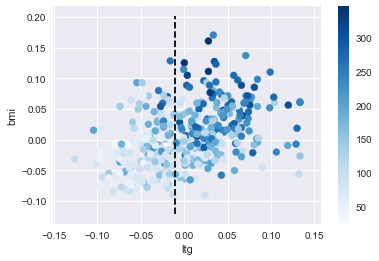

In [2]:
ltg_split = -0.01
plt.scatter(ltg, bmi,  c=y, cmap="Blues")
plt.vlines(ltg_split, *plt.gca().get_ylim(), linestyles='dashed')
plt.colorbar()
plt.xlabel('ltg'); plt.ylabel('bmi');

However, that region still contains a fair number of low (blue) values, so we can similarly bisect the region using a `bmi` value of -0.03 as a threshold value:

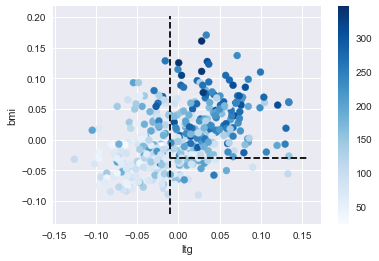

In [3]:
bmi_split = -0.03
plt.scatter(ltg, bmi,  c=y, cmap="Blues")
plt.vlines(ltg_split, *plt.gca().get_ylim(), linestyles='dashed')
plt.hlines(bmi_split, ltg_split, plt.gca().get_xlim()[1], linestyles='dashed')
plt.colorbar()
plt.xlabel('ltg'); plt.ylabel('bmi');

We can use this partition to create a piecewise-constant function, which returns the average value of the observations in each region defined by the threshold values. We could then use this rudimentary function as a predictive model.

In [4]:
np.mean(y[(bmi>bmi_split) & (ltg>ltg_split)])

197.69417475728156

In [5]:
np.mean(y[(bmi<=bmi_split) & (ltg>ltg_split)])

136.93939393939394

In [6]:
np.mean(y[ltg<ltg_split])

108.36945812807882

The choices for splitting the variables here were relatively arbitrary. Better choices can be made using a cost function $C$, such as **residual sums of squares** (RSS).

$$C = \sum_j \sum_{i \in R_j} (y_i - \hat{y}_{R_j})^2$$

where $\hat{y}_{R_j}$ is the mean response for the training observations in the jth region.

### Exercise

Use residual sums of squares to select competitive threshold values for the predictive model defined above

In [7]:
#load the diabetes data set 
diabetes = load_diabetes()
y = diabetes['target']
bmi, ltg = diabetes['data'][:,[2,8]].T

#create function to take in data, and adding a mask for each threshold value and iterating over linear space 
def rss_cost(data, mask):
    this_cost = ((data[mask] - np.mean(data[mask]))**2).sum() 
    that_cost = ((data[~mask] - np.mean(data[~mask]))**2).sum()
    return this_cost + that_cost
    
ltg_space = np.linspace(ltg.min(), ltg.max())
ltg_cost = [rss_cost(y, ltg<c) for c in ltg_space]
ltg_opt = ltg_space[np.argmin(ltg_cost)]
print(ltg_opt)

-0.00419909151574


/Users/geenaildefonso/anaconda/envs/bios8366/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/geenaildefonso/anaconda/envs/bios8366/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
bmi_space = np.linspace(bmi[ltg>ltg_opt].min(), bmi[ltg>ltg_opt].max())
bmi_cost = [rss_cost(y[ltg>ltg_opt], bmi[ltg>ltg_opt]<c) for c in bmi_space]
bmi_opt = bmi_space[np.argmin(bmi_cost)]
print(bmi_opt)

0.0161861416032


/Users/geenaildefonso/anaconda/envs/bios8366/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/geenaildefonso/anaconda/envs/bios8366/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0,0.5,'bmi')

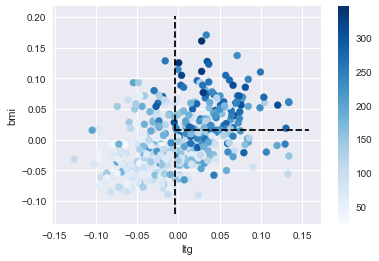

In [9]:
plt.scatter(ltg, bmi,  c=y, cmap="Blues")
plt.vlines(ltg_opt, *plt.gca().get_ylim(), linestyles='dashed')
plt.hlines(bmi_opt, ltg_opt, plt.gca().get_xlim()[1], linestyles='dashed')
plt.colorbar()
plt.xlabel('ltg'); plt.ylabel('bmi')

The recursive partitioning demonstrated above results in a **decision tree**. The regions defined by the trees are called *terminal nodes*. Locations at which a predictor is split, such as `bmi`=-0.03, are called  *internal nodes*. As with this simple example, splits are not generally symmetric, in the sense that splits do not occur similarly on all branches.

Now consider a subset of three variables from the Titanic dataset, which we would like to use to predict survival from the disaster. The following describes one such decision tree:

- We first check if gender of the passenger is male. If "no", we follow the right branch and end up in a leaf where the probability of survival is $p(y=1,x_1=F)=0.73$, so we predict survival ($y=1$) at this node (36% of observations fall under this leaf)
- If the passenger is male, we then check the age of the passenger. If he is older than 9.5 years, then the probability of survival $p(y=1,x_1=M,x_2>9.5)=0.17$, so we predict death ($y=0$). 
- If, on the other hand, the passenger is younger than 9.5 years, we then check if the number of siblings and spouses on board was higher than 2.5; if "yes", then the probability of survival  $p(y=1, x_1=M, x_2>9.5, x_3>2.5)=0.05$, so we predict death, otherwise we predict survival with $p(y=1, x_1=M, x_2>9.5 , x_3 \lt 2.5)=0.89$. 

Hence, these probabilities are just the empirical fraction of positive examples that satisfy each conjunction of feature values, which defines a path from the root to a leaf.

![titanic tree](http://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

There is no way to feasibly evaluate all possible partitions. Instead, the strategy is to use a top-down, **greedy** approach that is optimal (according to a particular cost function) for the current split only. By "greedy", we mean that at each step it chooses the most advantageous binary partition, not taking into account the impact of the choice on the quality of subsequent partitions.

$$(j^*, t^*) = \text{argmin}_{j,t} C(\{\mathbf{x}_i,y_i: x_{ij} \le t\}) + C(\{\mathbf{x}_i,y_i: x_{ij} \gt t\})$$

where $C$ is a cost function, $j$ and $t$ are a variable index and cutpoint, respectively. We will restrict consideration to **binary partitions**.

## Classification Trees

In addition to regression trees, we can also use decision trees on categorical outcomes, and these are called classification trees. The primary difference in implementation is that residual sums of squares is no longer an appropriate splitting criterion.

### Entropy

An alternative splitting criterion for decision tree learning algorithms is *information gain*. It measures how well a particular attribute distinguishes among different target classifications. Information gain is measured in terms of the expected reduction in the entropy or impurity of the data. The entropy of a set of probabilities is:

$$H(p) = -\sum_i p_i log_2(p_i)$$

If we have a set of binary responses from some variable, all of which are positive/true/1, then knowing the values of the variable does not hold any predictive value for us, since all the outcomes are positive. Hence, the entropy is zero:

In [10]:
import numpy as np

entropy = lambda p: -np.sum(p * np.log2(p)) if not 0 in p else 0

In [11]:
entropy([.4,.6])

0.97095059445466858

However, if the variable splits responses into equal numbers of positive and negative values, then entropy is maximized, and we wish to know about the feature:

In [12]:
entropy([0.5, 0.5])

1.0

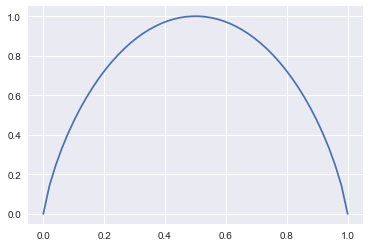

In [13]:
pvals = np.linspace(0, 1)        
plt.plot(pvals, [entropy([p,1-p]) for p in pvals])

The entropy calculation tells us how much additional information we would obtain with knowledge of the variable.

So, if we have a set of candidate covariates from which to choose as a node in a decision tree, we should choose the one that gives us the most information about the response variable (*i.e.* the one with the highest entropy).

### Misclassification Rate

Alternatively, we can use the misclassification rate:

$$C(j,t) = \frac{1}{n_{jt}} \sum_{y_i: x_{ij} \gt t} I(y_i \ne \hat{y})$$

where $\hat{y}$ is the most probable class label and $n_{ij}$ is the number of observations in the data subset obtained from splitting via $j,t$.

### Gini index

The Gini index is simply the expected error rate:

$$C(j,t) = \sum_{k=1}^K \hat{\pi}_{jt}[k] (1 - \hat{\pi}_{jt}[k]) = 1 - \sum_{k=1}^K \hat{\pi}_{jt}[k]^2$$

where $\hat{\pi}_{jt}[k]$ is the probability of an observation being correctly classified as class $k$ for the data subset obtained from splitting via $j,t$ (hence, $(1 - \hat{\pi}_{jt}[k])$ is the misclassification probability).

In [14]:
gini = lambda p: 1. - (np.array(p)**2).sum()

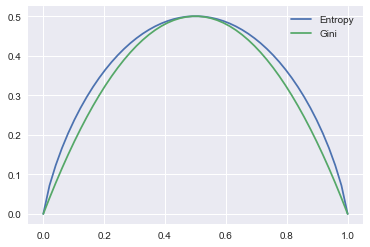

In [15]:
#comparison of entropy and the Gini index 
pvals = np.linspace(0, 1)        
plt.plot(pvals, [entropy([p,1-p])/2. for p in pvals], label='Entropy')
plt.plot(pvals, [gini([p,1-p]) for p in pvals], label='Gini')
plt.legend()

## ID3

A given cost function can be used to construct a decision tree via one of several algorithms. The Iterative Dichotomiser 3 (ID3) is on such algorithm, which uses entropy, and a related concept, *information gain*, to choose features and partitions at each classification step in the tree.

Information gain is the difference between the current entropy of a system and the entropy measured after a feature is chosen. If $S$ is a set of examples and $X$ is a possible feature on which to partition the examples, then:

$$G(S,X) = \text{Entropy}(S) - \sum_{x \in X} \frac{\#(S_x)}{\#(S)} \text{Entropy}(S_x)$$

where $\#$ is the count function and $x$ is a particular value of $X$.

Let's say $S$ is a set of survival events, $S = \{s_1=survived, s_2=died, s_3=died, s_4=died\}$ and a particular variable $X$ can have values $\{x_1, x_2, x_3\}$. To perform a sample calculation of information gain, we will say that:

* $X(s_1) = x_2$
* $X(s_2) = x_2$
* $X(s_3) = x_3$
* $X(s_4) = x_1$

The current entropy of this state is:

$$\begin{align}
\text{Entropy}(S) &= -p^{(+)} \log_2(p^{(+)}) - p^{(-)} \log_2(p^{(-)}) \\
&= -0.25 \log_2(0.25) - 0.75 \log_2(0.75) \\
&= 0.5 + 0.311 = 0.811
\end{align}$$

Now, we need to compute the information after selecting variable $X$, which is the sum of three terms:

$$\begin{align}
\frac{\#(S_{x1})}{\#(S)} \text{Entropy}(S) &= 0.25 (-0 \log_2(0) - 1 \log_2(1)) = 0\\
\frac{\#(S_{x2})}{\#(S)} \text{Entropy}(S) &= 0.5 (-0.5 \log_2(0.5) - 0.5 \log_2(0.5) = 0.5\\
\frac{\#(S_{x3})}{\#(S)} \text{Entropy}(S) &= 0.25 (-0 \log_2(0) - 1 \log_2 1) = 0\\
\end{align}$$

Therefore, the information gain is:

$$G(S,X) = 0.811 - (0 + 0.5 + 0) = 0.311$$

This algorithm is implemented in the following function:

In [16]:
import numpy as np

def info_gain(X, y, feature):
    # Calculates the information gain based on entropy
    
    gain = 0
    n = len(X)

    # List the values that feature can take
    values = list(set(X[feature]))

    feature_counts = np.zeros(len(values))
    E = np.zeros(len(values))
    ivalue = 0
    
    # Find where those values appear in X[feature] and the corresponding class
    for value in values:
        
        new_y = [y[i] for i,d in enumerate(X[feature].values) if d==value]
        feature_counts[ivalue] += len(new_y)

        # Get the values in newClasses
        class_values = list(set(new_y))

        class_counts = np.zeros(len(class_values))
        iclass = 0
        for v in class_values:
            for c in new_y:
                if c == v:
                    class_counts[iclass] += 1 
            iclass += 1
        
        nc = float(np.sum(class_counts))
        new_entropy = entropy([class_counts[c] / nc for c in range(len(class_values))])
        E[ivalue] += new_entropy

        # Computes both the Gini gain and the entropy
        gain += float(feature_counts[ivalue])/n * E[ivalue]
        ivalue += 1
        
    return gain 

Consider a few variables from the titanic database:

In [17]:
titanic = pd.read_excel("../data/titanic.xls", "titanic")
titanic.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Here, we have selected pasenger class (`pclass`), sex, port of embarcation (`embarked`), and a derived variable called `adult`. We can calculate the information gain for each of these.

In [18]:
X = titanic.copy()
y = X.pop('survived')
X['adult'] = titanic.age>17

info_gain(X, y, 'pclass')

0.8890147580167741

In [19]:
info_gain(X, y, 'sex')

0.75391729814273911

In [20]:
info_gain(X, y, 'embarked') #port of embarcation 

0.93350672011351277

In [21]:
info_gain(X, y, 'adult') #choose adult for the first split because of the largest informaton gain 

0.95919244744071819

Hence, the ID3 algorithm computes the information gain for each variable, selecting the one with the highest value (in this case, `adult`). In this way, it searches the "tree space" according to a greedy strategy.

A tree can be constructed by recursively selecting the feature from the current dataset with the largest information gain, then removing it from the datset. Recursion stops when there are either no variables remaining, or there is only one class left in the subset (*e.g.* all `True` or all `False`).

The ID3 algorithm is as follows:

> * if all response data have the same class:
> 
>     - return leaf with data label
>     
> * else if no features:
> 
>     - return leaf with most common label
>     
> * else:
> 
>     - choose variable $X'$ that maximizes information gain to be a tree node
>     - add branch from node for each value of $X'$
>     - for each branch of node:
>     
>         * calculate $S_{x}$ by removing $X'$ from $S$
>         * set $S=S_{x}$ and call algorithm again 

The greedy approach of maximizing information gain at each step tends to bias solutions towards smaller trees.

## Decision Trees in `scikit-learn`

Classification trees, either binary or multi-class, are implemented in `scikit-learn` in the `DecisionTreeClassifier` class. Where trees are binary, it expects the response variable to be coded as `[-1,1]` for negative and positive outcomes.

Let's build a decision tree on the wine dataset.

In [22]:
wine = pd.read_table("../data/wine.dat", sep='\s+')

attributes = ['Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']

grape = wine.pop('region') #region is the grape 
y = grape
wine.columns = attributes
X = wine

In [23]:
from sklearn import tree
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.4, random_state=0)

clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_features="auto",
                                  min_samples_leaf=10)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

If you have [GraphViz](http://www.graphviz.org) and `pydot` installed, you can draw the resulting tree:

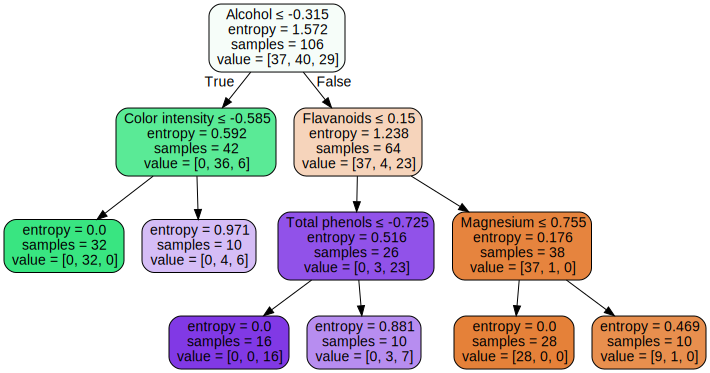

In [24]:
import graphviz
#normalized values in the tree
gv_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=attributes,  
                     filled=True, rounded=True,  
                     special_characters=True) 

graphviz.Source(gv_data)

In [25]:
preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['actual'], 
            colnames=['prediction'])

prediction,1,2,3
actual,,,
1,22,0,0
2,3,19,9
3,0,0,19


### Pruning

Despite the **inductive bias** associated with trees that tend to make them small, the ID3 algorithm continues choosing nodes and branches until either it runs out of variables, or all outputs are of the same class. This can clearly lead to overfit trees.

To prevent overfitting, we can **stop growing** the tree if the information gain (or reduction in error, etc.) is not sufficient to justify the extra complexity of adding another node. However, this simple rule is not optimal, because an uninformative subtree can lead to informative ones later on. 

The standard approach is therefore to grow a full tree, and then to **prune** it. The easiest approach is to remove branches that give the least increase in the error (information gain). To determine how far back to prune, we can evaluate the cross-validated error on each candidate pruning, and then pick the tree whose CV error is within 1 standard error of the minimum.

Analogous to the lasso or ridge regression, we can **penalize** the number of terminal nodes in a tree:

$$\sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i - \hat{y}_{R_j})^2 + \alpha |T|$$

where $|T|$ is the number of terminal nodes in tree T.

### Pruned Decision Tree Algorithm

1. Use recursive binary splitting to grow a large tree, such that each terminal node has fewer than some minimum number of observations.
2. Apply pruning to obtain a sequence of best subtrees, as a function of $\alpha$.
3. Use k-fold cross-validation to choose $\alpha$. Average results and pick $\alpha$ to minimize the average error.
4. Return subtree from (2) that corresponds to chosen $\alpha$.


##  Averaging Trees

Decision trees have several advantages: 

* ease of interpretation
* easy of implementation
* handles continuous and discrete features (and mixed)
* invariant to monotone transformation of features
* variable selection automated (ignores redundant variables)
* robust
* scalable (can handle huge datasets)

However, relative to other statistical learning methods, trees do not predict very accurately, due to the greedy nature of the tree construction algorithm. Also, trees tend to be **unstable**, as small changes to the inputs can have large effects on the structure of the tree; poor decisions near the root of the tree will propogate to the rest of the tree. Hence, trees are **high variance** (*i.e.* noisy) estimators.

One way to reduce the variance of an estimate is to average together many estimates. In the case of decision trees, we can train $T$ different trees on random subsets of the data (with replacement) then average according to:

$$\hat{f}(\mathbf{x}) = \frac{1}{T} \sum_{i=1}^T f_t(\mathbf{x})$$

where $f_t$ is the $t^{th}$ tree. This approach is called "bootstrap aggregating", or **bagging**.

Note that, since we are averaging over trees, there is *no need to prune*. With bagging, we reduce variance by averaging, rather than by pruning.

In [26]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(n_jobs=4, oob_score=True)
bc

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=4, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

In [27]:
bc.fit(X_train, y_train)

preds = bc.predict(X_test)
pd.crosstab(y_test, preds, rownames=['actual'], 
            colnames=['prediction'])

prediction,1,2,3
actual,,,
1,22,0,0
2,0,29,2
3,0,0,19


Test error of a bagged model is measured by estimating **out-of-bag error**.

On average, each bagged tree uses about 2/3 of observations, leaving the remaining third as "out-of bag". The response for the ith observation for each of the trees in which that observation was excluded (on average, B/3) is averaged. This essentially the same as performing leave-one-out (LOO) cross-validation.

In [28]:
bc.oob_score_

0.91509433962264153

This approach is an **ensemble learning** method, because it takes a set of *weak* learners, and combines them to construct a *strong* learner that is more robust, with lower generalization error.

An average of B trees, each with variance $\sigma^2$, has variance $\sigma^2/B$. If the variables are simply identically distributed, with positive pairwise correlation $\rho$, then the variance of the average of the B trees is:

$$\rho \sigma^2 + \frac{1-\rho}{B}\sigma^2$$

As the number of trees becomes large, the second term goes to zero. Further reductions in variance are limited by the size of the **correlation** among the trees $\rho$.

## Random Forests

**Random forests** improves upon bagging by creating a set of decision trees that are less correlated than bootstrapped trees. This is done by selecting from only a subset $m$ out of $M$ possible predictors at each split. Typically, we choose approximately the square root of the available number.

This procedure is used to create a set of trees, most of which will be poor at predicting a given observation. However, classification is based on a *majority vote* of the constituent trees.

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=4)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['actual'], 
            colnames=['prediction'])

prediction,1,2,3
actual,,,
1,22,0,0
2,1,27,3
3,0,0,19


With random forests, it is possible to quantify the **relative importance** of feature inputs for classification. In scikit-learn, the Gini index (recall, a measure of error reduction) is calculated for each internal node that splits on a particular feature of a given tree, which is multiplied by the number of samples that were routed to the node (this approximates the probability of reaching that node). For each variable, this quantity is averaged over the trees in the forest to yield a measure of importance.

In [30]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Flavanoids (0.203241)
2. OD280/OD315 of diluted wines (0.172363)
3. Color intensity (0.147578)
4. Alcohol (0.138639)
5. Hue (0.126596)
6. Proanthocyanins (0.056822)
7. Proline (0.042809)
8. Alcalinity of ash (0.035301)
9. Total phenols (0.034037)
10. Malic acid (0.023954)
11. Nonflavanoid phenols (0.010921)
12. Magnesium (0.007737)
13. Ash (0.000000)


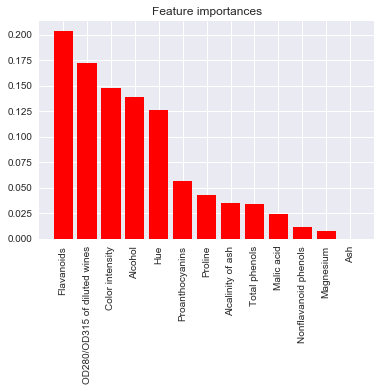

In [31]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]]);

`RandomForestClassifier` uses the Gini impurity index by default; one may instead use the entropy information gain as a criterion.

In [32]:
rf = RandomForestClassifier(n_jobs=4, criterion='entropy')
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Color intensity (0.225768)
2. Flavanoids (0.217303)
3. OD280/OD315 of diluted wines (0.175355)
4. Proline (0.137824)
5. Hue (0.064688)
6. Magnesium (0.044810)
7. Total phenols (0.041487)
8. Proanthocyanins (0.041102)
9. Malic acid (0.027145)
10. Alcohol (0.011505)
11. Alcalinity of ash (0.007720)
12. Ash (0.005293)
13. Nonflavanoid phenols (0.000000)


## Decision Tree Regression

While it may not be apparent how to use trees for regression analysis, it requires only a straightforward modification to the algorithm. A popular tree-based regression algorithm is the **classification and regression tree** (CART).

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. We can use a decision tree regression model to fit the data.

In [33]:
daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)


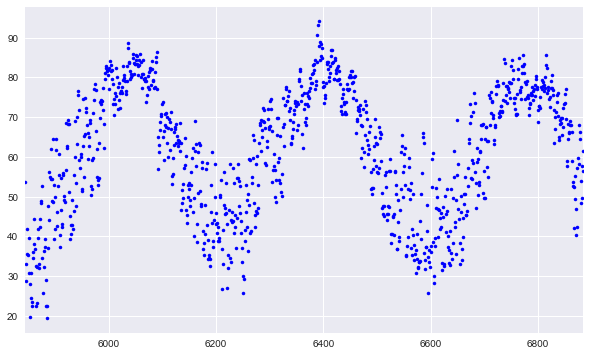

In [34]:
daily_temps.temp[daily_temps.year>2010].plot(style='b.', figsize=(10,6))

In this context, none of the cost functions considered so far would be appropriate. Instead, it would be more suitable to use something like mean squared error (MSE) to guide the growth of the tree. With this, we can proceed to choose:

1. a variable on which to split the dataset
2. a value of the variable at which to place a node (in the case of continuous features)

Recall that the output of a tree is just a constant value for each leaf; here, we simply return the average of all the response values in the region. Thus, we choose a cut point that minimizes the MSE at each step.

In [35]:
# Transmogrify data
y = daily_temps.temp[daily_temps.year>2010]
X = np.atleast_2d(np.arange(len(y))).T

In [36]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=7, min_samples_leaf=2)
clf.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

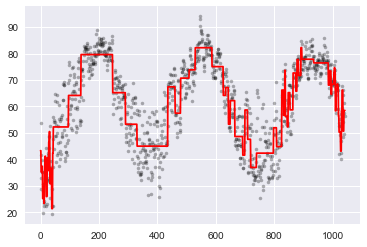

In [37]:
X_fit = np.linspace(0, len(X), 1000).reshape((-1, 1))
y_fit_1 = clf.predict(X_fit)

plt.plot(X.ravel(), y, '.k', alpha=0.3)
plt.plot(X_fit.ravel(), y_fit_1, color='red');

A single decision tree allows us to estimate the signal in a non-parametric way,
but clearly has some issues.  In some regions, the model shows high bias and
under-fits the data
(seen in the long flat lines which don't follow the contours of the data),
while in other regions the model shows high variance and over-fits the data
(reflected in the narrow spikes which are influenced by noise in single points).

One way to address this is to use an ensemble method, like random forests, so that the
effects of their over-fitting go away on average. 

Here we will use a random forest of 200 trees to reduce the tendency of each
tree to over-fitting the data.

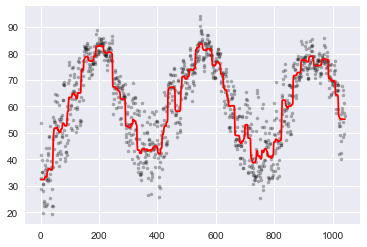

In [38]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=200, max_depth=9, 
                            min_samples_leaf=10)
clf.fit(X, y)

y_fit_200 = clf.predict(X_fit)

plt.plot(X.ravel(), y, '.k', alpha=0.3)
plt.plot(X_fit.ravel(), y_fit_200, color='red')

### Prediction intervals

The predictions from random forests are not accompanied by estimates of uncertainty, as is the case with Bayesian regression models. However, it is possible to obtain probability intervals using a random forests approach. Since we are using an ensemble of trees, it is possible to track *all* predicted values for all leaf nodes in a random forest, rather than just the mean or modal value. This results in conditional distributions $P(y|X=x)$ for every x, from which percentiles can be calculated for desired endpoints in a prediction interval. This approach is called **quantile regression forests**.

To implement quantile regression forests in scikit-learn, we need to allow each tree to grow so that each leaf node contains exactly one value. Then, each tree returns a single response variable, from which a conditional distribution can be approximated. Of course, fully expanding trees will result in overfitting, but these can also be cross-validated.

scikit-learn does not automatically calculate prediction intervals, but the estimators from each constitutent tree in the `RandomForestRegressor` is avaialable, from which individual tree predictions can be made.

In [39]:
def prediction_intervals(mod, X, alpha=0.05):
    preds = [pred.predict(X) for pred in mod.estimators_]
    lower = np.percentile(preds, 100*(alpha/2), axis=0)
    upper = np.percentile(preds, 100*(1-alpha/2), axis=0)
    return lower, upper, np.array(preds)

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.4, random_state=0)

In [41]:
clf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=1)
clf.fit(X_train, y_train)

y_fit_200 = clf.predict(X_fit)

In [42]:
lower, upper, preds = prediction_intervals(clf, X_test, alpha=0.1)

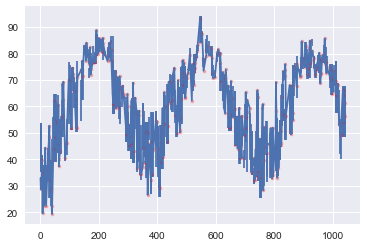

In [43]:
x_sorted = np.sort(X_test.ravel())
order = np.argsort(X_test.ravel())
plt.errorbar(x_sorted, y_test.values[order], 
             yerr=[(y_test.values-lower)[order], (upper-y_test.values)[order]])
plt.plot(X_test, y_test, '.r', alpha=0.3)

### Exercise

Selecting the optimal random forest regression model for the nashville daily temperature data via cross-validation in `scikit-learn`. Use the number of estimators and the maximim leaf nodes as tuning parameters.

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
# daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
#                             names=['month','day','year','temp'], na_values=-99)

In [49]:
# # Transmogrify data
# y = daily_temps.temp[daily_temps.year>2010]
# X = np.atleast_2d(np.arange(len(y))).T

In [52]:
parameters = {'n_estimators':[10, 50, 100, 200, 300],
              'max_leaf_nodes':[3, 5, 7, 9, 11, 13]}
rf = RandomForestRegressor()
clf_grid = GridSearchCV(rf, parameters)

In [53]:
from sklearn.utils import shuffle 

In [54]:
clf_grid.fit(*shuffle(X,y))

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900], 'max_leaf_nodes': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [ ]:
rf_best = clf_grid.best_estimator_
X_fit = np.linspace(0, len(X), 1000).reshape((-1, 1))
y_fit_best = rf_best.predict(X_fit)

In [ ]:
print((rf_best.n_estimators, rf_best.max_depth))

In [ ]:
plt.plot(X.ravel(), y, '.k', alpha=0.3)
plt.plot(X_fit.ravel(), y_fit_best, color='red')

## References

Meinshausen, N. [Quantile Regression Forests](http://www.jmlr.org/papers/volume7/meinshausen06a/meinshausen06a.pdf) Journal of Machine Learning Research 7 (2006) 983–999

T. Hastie, R. Tibshirani and J. Friedman. (2009) [Elements of Statistical Learning: Data Mining, Inference, and Prediction](http://statweb.stanford.edu/~tibs/ElemStatLearn/), second edition. Springer.
